## Location for a Supermarket in Barcelona

### 1. Download and Explore Barcelona geographical coordinates dataset

Barcelona has a total of 10 boroughs and 73 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the districs and the neighborhoods.

Link to the dataset: https://vangdata.carto.com/tables/shapefiles_barcelona_distrito/public

First, let's download all the dependencies that we will need.

In [13]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import csv # implements classes to read and write tabular data in CSV form

print('Libraries imported.')

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - anaconda/linux-64::grpcio==1.16.1=py36hf8bcb03_1 -> openssl[version='>=1.1.1,<1.1.2.0a0']

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


WARNING conda.base.context:use_only_tar_bz2(632): Co

The json file is downloaded and it is placed on the server. So run a `wget` command and access the data.

In [2]:
!wget -q -O 'barcelona_data.json' https://cdn.rawgit.com/martgnz/bcn-geodata/master/barris/barris_geo.json
print('Data downloaded!')


Data downloaded!


#### Load and explore the data

In [3]:
with open('barcelona_data.json') as json_data:
    barcelona_data = json.load(json_data)

All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, define a new variable that includes this data.

In [4]:
neighborhoods_data = barcelona_data['features']

Take a look at the first item in this list.

In [5]:
#neighborhoods_data[0]

#### Tranform the data into a *pandas* dataframe
The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. Start by creating an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['N_Distri'] 
    neighborhood_name = data['properties']['N_Barri'] 
    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[0][0][1]
    neighborhood_lon = neighborhood_latlon[0][0][0]
    
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
neighborhoods.shape

(73, 4)

Now, we are sure that there are 73 neighborhoods

In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 73 neighborhoods.


In [11]:
neighborhoods.to_csv('Barcelona_GEO.csv',index=False)

#### Use geopy library to get the latitude and longitude values of Barcelona.

In [15]:
address = 'Barcelona, BCN'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

41.40646725 2.16306377154439


#### Create a map of Barcelona with neighborhoods.

**Folium** is a great visualization library. We can zoom into the below map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

In [16]:
# create map of Barcelona using latitude and longitude values
map_Barcelona = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=0.3,
        parse_html=False).add_to(map_Barcelona)  
    
map_Barcelona

### 2. Segmenting and Clustering Neighborhoods 

### Import necessary Libraries

In [17]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - anaconda/linux-64::grpcio==1.16.1=py36hf8bcb03_1 -> openssl[version='>=1.1.1,<1.1.2.0a0']

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


WARNING conda.base.context:use_only_tar_bz2(632): Co

### Explore Dataset

In [18]:
BCN_Geo=pd.read_csv('Barcelona_GEO.csv')
print('Data downloaded!')

Data downloaded!


In [19]:
BCN_Geo['Borough'].value_counts().to_frame()

,Borough
Nou Barris,13
Horta-Guinardó,11
Sant Martí,10
Sants-Montjuïc,8
Sant Andreu,7
Eixample,6
Sarrià-Sant Gervasi,6
Gràcia,5
Ciutat Vella,4
Les Corts,3


In [20]:
print(BCN_Geo.Borough.unique())

['Ciutat Vella' 'Eixample' 'Sants-Montjuïc' 'Les Corts'
 'Sarrià-Sant Gervasi' 'Gràcia' 'Horta-Guinardó' 'Nou Barris'
 'Sant Andreu' 'Sant Martí']


### Segmenting and Clustering Neighborhoods -  Barcelona Center

In [21]:
Center_Geo = BCN_Geo.loc[(BCN_Geo['Borough'] == 'Eixample')|(BCN_Geo['Borough'] == 'Sants-Montjuïc')|(BCN_Geo['Borough'] == 'Sarrià-Sant Gervasi')|(BCN_Geo['Borough'] == 'Gràcia')]
Center_Geo = Center_Geo.reset_index(drop=True)
Center_Geo

,Borough,Neighborhood,Latitude,Longitude
0,Eixample,el Fort Pienc,41.39142593401981,2.182389633367708
1,Eixample,la Sagrada Família,41.406032157337094,2.183361528532187
2,Eixample,la Dreta de l'Eixample,41.39998519624629,2.173315981922499
3,Eixample,l'Antiga Esquerra de l'Eixample,41.386303663440906,2.164126034567323
4,Eixample,la Nova Esquerra de l'Eixample,41.38212775566621,2.158570079959219
5,Eixample,Sant Antoni,41.3859161565667,2.164846888163389
6,Sants-Montjuïc,el Poble Sec,41.375294238214316,2.149816362663807
7,Sants-Montjuïc,la Marina del Prat Vermell,41.372297761678865,2.177634929704094
8,Sants-Montjuïc,la Marina de Port,41.36604062609688,2.14214209587741
9,Sants-Montjuïc,la Font de la Guatlla,41.36604062609688,2.14214209587741


In [22]:
print('Barcelona Center has {} boroughs and {} neighborhoods.'.format(
        len(Center_Geo['Borough'].unique()),
        Center_Geo.shape[0]
    )
)

Barcelona Center has 4 boroughs and 25 neighborhoods.


In [23]:
Center_Geo.to_csv('Center_GEO.csv',index=False)

### Segmenting and Clustering Neighborhoods -  Barcelona Suburb

In [24]:
Suburb_Geo = BCN_Geo.loc[(BCN_Geo['Borough'] == 'Nou Barris')|(BCN_Geo['Borough'] == 'Horta-Guinardó')|(BCN_Geo['Borough'] == 'Sant Martí')|(BCN_Geo['Borough'] == 'Sant Andreu')|(BCN_Geo['Borough'] == 'Ciutat Vella')|(BCN_Geo['Borough'] == 'Les Corts')]
Suburb_Geo = Suburb_Geo.reset_index(drop=True)
Suburb_Geo

,Borough,Neighborhood,Latitude,Longitude
0,Ciutat Vella,el Raval,41.38546968235703,2.170043729484323
1,Ciutat Vella,el Barri Gòtic,41.38127041329914,2.182463146983109
2,Ciutat Vella,la Barceloneta,41.384934944079056,2.199722962413001
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.39142593401981,2.182389633367708
4,Les Corts,les Corts,41.3925389469222,2.1299439208967
5,Les Corts,la Maternitat i Sant Ramon,41.379433561582665,2.12913926505408
6,Les Corts,Pedralbes,41.40109422432195,2.102913725441463
7,Horta-Guinardó,el Baix Guinardó,41.41120501510022,2.174287667140717
8,Horta-Guinardó,Can Baró,41.41545162913898,2.167294636826141
9,Horta-Guinardó,el Guinardó,41.42543850962799,2.17616061750463


In [25]:
print('Barcelona Suburb has {} boroughs and {} neighborhoods.'.format(
        len(Suburb_Geo['Borough'].unique()),
        Suburb_Geo.shape[0]
    )
)

Barcelona Suburb has 6 boroughs and 48 neighborhoods.


In [26]:
Suburb_Geo.to_csv('Suburb_GEO.csv',index=False)

### 3. Analyze Each Neighborhood

#### 3.1 Population & Demographics in the city of Barcelona

In [27]:
#neighborhoods_data[0]

In [28]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Men','Women','Area','Latitude', 'Longitude'] 

# instantiate the dataframe
Demo_BCN = pd.DataFrame(columns=column_names)

In [29]:
Demo_BCN

,Borough,Neighborhood,Men,Women,Area,Latitude,Longitude


In [30]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['N_Distri'] 
    neighborhood_name = data['properties']['N_Barri'] 
    neighborhood_men = data['properties']['Homes'] 
    neighborhood_women = data['properties']['Dones'] 
    neighborhood_area = data['properties']['Area'] 

    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[0][0][1]
    neighborhood_lon = neighborhood_latlon[0][0][0]
    
    
    Demo_BCN = Demo_BCN.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Men': neighborhood_men,
                                          'Women': neighborhood_women,
                                          'Area': neighborhood_area,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [31]:
#Demo_BCN.head()

In [32]:
Demo_BCN.to_csv('Demo_BCN.csv',index=False)

In [33]:

Demo_BCN['Poblation'] = Demo_BCN['Men'] + Demo_BCN['Women']
Demo_BCN['Index Demographic'] = Demo_BCN['Poblation'] / Demo_BCN['Area']

Demo_BCN.head()


,Borough,Neighborhood,Men,Women,Area,Latitude,Longitude,Poblation,Index Demographic
0,Ciutat Vella,el Raval,26553,21850,1.098393e+06,41.3855,2.17004,48403,0.0440671
1,Ciutat Vella,el Barri Gòtic,8368,7508,8.419051e+05,41.3813,2.18246,15876,0.0188572
2,Ciutat Vella,la Barceloneta,7581,7631,1.313868e+06,41.3849,2.19972,15212,0.011578
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",11466,11390,1.114299e+06,41.3914,2.18239,22856,0.0205116
4,Eixample,el Fort Pienc,15039,16924,9.289010e+05,41.3914,2.18239,31963,0.0344095


In [34]:
Demo_BCN.drop(['Men', 'Women', 'Area', 'Latitude', 'Longitude'], axis=1, inplace=True)

# let's view the first five elements and see how the dataframe was changed
Demo_BCN.head()

,Borough,Neighborhood,Poblation,Index Demographic
0,Ciutat Vella,el Raval,48403,0.0440671
1,Ciutat Vella,el Barri Gòtic,15876,0.0188572
2,Ciutat Vella,la Barceloneta,15212,0.011578
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",22856,0.0205116
4,Eixample,el Fort Pienc,31963,0.0344095


For consistency, ensure that all column labels of type string.

In [35]:
# let's examine the types of the column labels
all(isinstance(column, str) for column in Demo_BCN.columns)

True

So if we print the dimension of the data, we get:

In [37]:
print ('data dimensions:', Demo_BCN.shape)

data dimensions: (73, 4)


In [38]:
Demo_BCN.sort_values(['Poblation'], ascending=False, axis=0, inplace=True)
Demo_BCN.head(10)

,Borough,Neighborhood,Poblation,Index Demographic
8,Eixample,la Nova Esquerra de l'Eixample,58224,0.0435269
59,Sant Andreu,Sant Andreu,56818,0.0308594
5,Eixample,la Sagrada Família,51623,0.0491184
30,Gràcia,la Vila de Gràcia,50928,0.0384066
0,Ciutat Vella,el Raval,48403,0.0440671
25,Sarrià-Sant Gervasi,Sant Gervasi - Galvany,47043,0.0283577
18,Les Corts,les Corts,46412,0.0328564
6,Eixample,la Dreta de l'Eixample,43994,0.0207186
7,Eixample,l'Antiga Esquerra de l'Eixample,42161,0.0341536
17,Sants-Montjuïc,Sants,41313,0.0376339


In [39]:
Demo_BCN.tail()

,Borough,Neighborhood,Poblation,Index Demographic
57,Sant Andreu,Baró de Viver,2541,0.0110517
46,Nou Barris,Can Peguera,2295,0.0192027
55,Nou Barris,Vallbona,1348,0.00225497
11,Sants-Montjuïc,la Marina del Prat Vermell,1138,7.96688e-05
41,Horta-Guinardó,la Clota,537,0.00301224


In [40]:
Demo_BCN.sort_values(['Index Demographic'], ascending=False, axis=0, inplace=True)
Demo_BCN.head()

,Borough,Neighborhood,Poblation,Index Demographic
16,Sants-Montjuïc,Sants - Badal,24344,0.0592947
31,Gràcia,el Camp d'en Grassot i Gràcia Nova,34356,0.0528934
62,Sant Andreu,Navas,22059,0.0521061
50,Nou Barris,Verdun,12294,0.0517782
63,Sant Martí,el Camp de l'Arpa del Clot,38361,0.0517181


In [41]:
Demo_BCN.tail()

,Borough,Neighborhood,Poblation,Index Demographic
39,Horta-Guinardó,Montbau,5110,0.00249671
55,Nou Barris,Vallbona,1348,0.00225497
53,Nou Barris,Torre Baró,2719,0.00153754
21,Sarrià-Sant Gervasi,"Vallvidrera, el Tibidabo i les Planes",4666,0.00040495
11,Sants-Montjuïc,la Marina del Prat Vermell,1138,7.96688e-05


In [42]:

#Step1:Clean the data

#Demo_BCN.drop(['Borough', 'Poblation'], axis=1, inplace=True)

# let's view the first five elements and see how the dataframe was changed
#Demo_BCN.head()

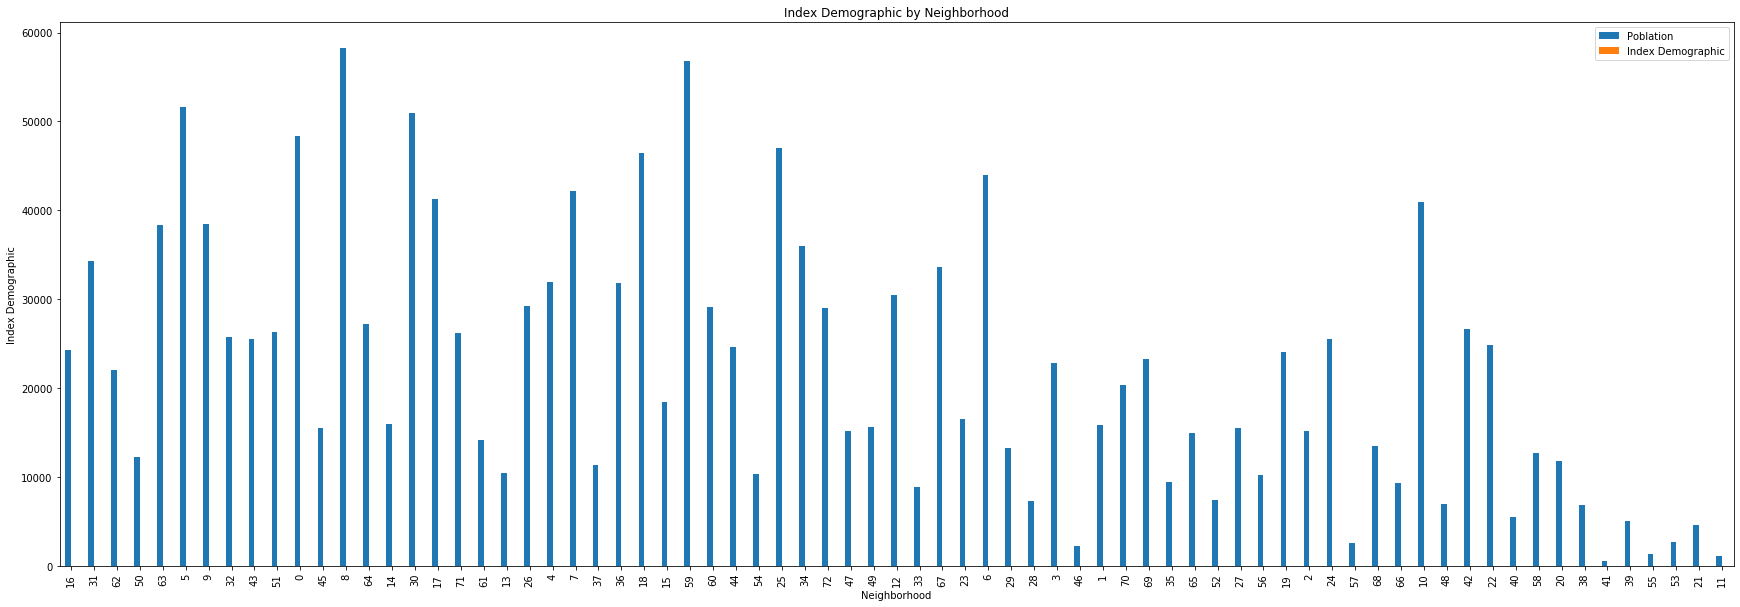

In [45]:
# step 2: plot data
Demo_BCN.plot(kind='bar', figsize=(30, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Index Demographic') # add y-label to the plot
plt.title('Index Demographic by Neighborhood') # add title to the plot

plt.show()

####  3.2 Unemployement by neighbourhood in the city of Barcelona 

For the analysis we will get data from Barcelona's City Hall Open Data Services as given below

https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-atur-sexe

#### Load and explore the data

In [89]:
# path of data 
path ='https://opendata-ajuntament.barcelona.cat/data/dataset/10dd343a-e81a-4f1f-9f95-e21b1ee71dcc/resource/0f1ed6a5-1224-4dec-94ee-92b542ad3c20/download'
BCN_umpl = pd.read_csv(path)
print('Data downloaded!')

Data downloaded!


In [90]:
#BCN_umpl.head(20)

In [91]:
BCN_umpl.shape

(1776, 9)

In [92]:
BCN_umpl.drop(BCN_umpl.columns[[0,1,2,4,7,8]], axis=1,inplace=True)
#BCN_umpl.head(20)

In [93]:
BCN_umpl.rename(columns = {'Nom_Districte' : 'Borough',
                   'Nom_Barri':'Neighborhood',
                   'Sexe':'Gender'}, inplace=True)
BCN_umpl.head(10)

,Borough,Neighborhood,Gender
0,Ciutat Vella,el Raval,Homes
1,Ciutat Vella,el Barri Gòtic,Homes
2,Ciutat Vella,la Barceloneta,Homes
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",Homes
4,Eixample,el Fort Pienc,Homes
5,Eixample,la Sagrada Família,Homes
6,Eixample,la Dreta de l'Eixample,Homes
7,Eixample,l'Antiga Esquerra de l'Eixample,Homes
8,Eixample,la Nova Esquerra de l'Eixample,Homes
9,Eixample,Sant Antoni,Homes


In [94]:
BCN_umpl['Borough'].value_counts().to_frame()

,Borough
Nou Barris,312
Horta-Guinardó,264
Sant Martí,240
Sants-Montjuïc,192
Sant Andreu,168
Eixample,144
Sarrià-Sant Gervasi,144
Gràcia,120
Ciutat Vella,96
Les Corts,72


### 3.3 List prices of commercial properties in the city of Barcelona

For the analysis we will get data from Barcelona's City Hall Open Data Services as given below

https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-mercat-immobiliari-lloguer-mitja-mensual

In [95]:
# path of data 
path ='https://opendata-ajuntament.barcelona.cat/data/dataset/69c3250b-100c-4d5b-a08e-0a191d9950e3/resource/3dc45b16-42a9-4f57-9863-e6d1a4f5869f/download/2018_lloguer_preu_trim.csv'
BCN_pric = pd.read_csv(path)
print('Data downloaded!')

Data downloaded!


In [96]:
#BCN_pric.head(20)

In [97]:
BCN_pric.shape

(584, 8)

In [98]:
BCN_pric.drop(BCN_pric.columns[[0,1,2,4,6]], axis=1,inplace=True)
#BCN_pric.head(20)

In [99]:
BCN_pric.rename(columns = {'Nom_Districte' : 'Borough',
                   'Nom_Barri':'Neighborhood',
                   'Preu':'Average monthly rent per surface'}, inplace=True)
BCN_pric.head()

,Borough,Neighborhood,Average monthly rent per surface
0,Ciutat Vella,el Raval,792.74
1,Ciutat Vella,el Barri Gòtic,998.40
2,Ciutat Vella,la Barceloneta,870.84
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",923.44
4,Eixample,el Fort Pienc,910.53


In [100]:
#LIMPIAR NAN

Identify the missing Data

In [103]:
missing_data = BCN_pric.isnull()
missing_data.head()

,Borough,Neighborhood,Average monthly rent per surface
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


In [104]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

Borough
False    584
Name: Borough, dtype: int64

Neighborhood
False    584
Name: Neighborhood, dtype: int64

Average monthly rent per surface
False    540
True      44
Name: Average monthly rent per surface, dtype: int64



In [136]:
BCN_pric.sort_values(['Average monthly rent per surface'], ascending=False, axis=0, inplace=True)
BCN_pric.head(100)

,Borough,Neighborhood,Average monthly rent per surface
166,Les Corts,Pedralbes,1849.52
20,Les Corts,Pedralbes,1799.91
169,Sarrià-Sant Gervasi,les Tres Torres,1746.01
239,Les Corts,Pedralbes,1615.31
23,Sarrià-Sant Gervasi,les Tres Torres,1613.41
242,Sarrià-Sant Gervasi,les Tres Torres,1567.91
93,Les Corts,Pedralbes,1563.31
96,Sarrià-Sant Gervasi,les Tres Torres,1467.07
168,Sarrià-Sant Gervasi,Sarrià,1443.71
241,Sarrià-Sant Gervasi,Sarrià,1422.80


In [134]:
BCN_pric=BCN_pric[0:500]

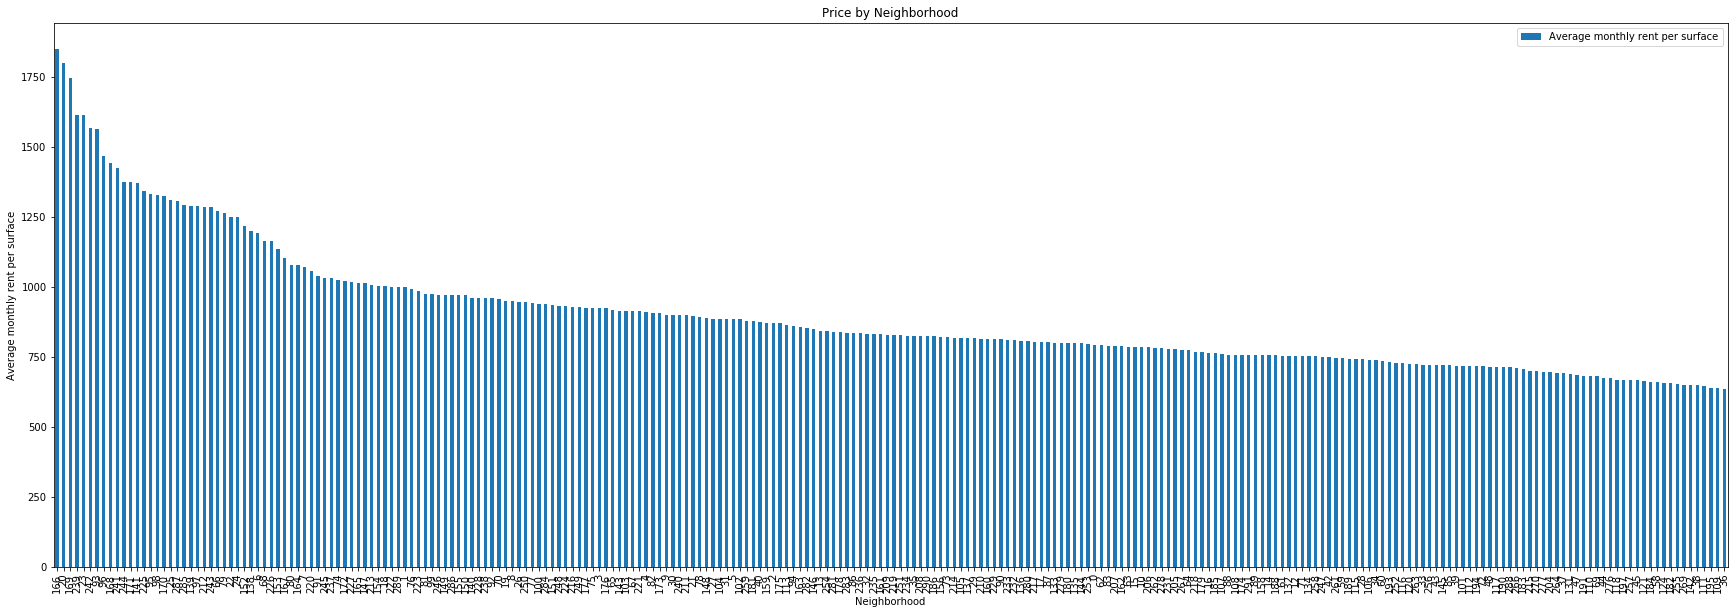

In [135]:
# step 2: plot data
BCN_pric.plot(kind='bar', figsize=(30, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Average monthly rent per surface') # add y-label to the plot
plt.title('Price by Neighborhood') # add title to the plot

plt.show()

### 4. Explore Supermarkets in Barcelona

### Import necessary Libraries

In [65]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - anaconda/linux-64::grpcio==1.16.1=py36hf8bcb03_1 -> openssl[version='>=1.1.1,<1.1.2.0a0']

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


WARNING conda.base.context:use_only_tar_bz2(632): Co

In [66]:
CLIENT_ID = 'OBYPB5FBXUVGFWWVEGQQDMRHRVPCMBZ0FLAYXGIEP2FVDYUV' # your Foursquare ID
CLIENT_SECRET = '10XZYCNAXY0YSPLREORFJKGZD4X4ERSQW0VBYKZLM1ZYXMFG' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OBYPB5FBXUVGFWWVEGQQDMRHRVPCMBZ0FLAYXGIEP2FVDYUV
CLIENT_SECRET:10XZYCNAXY0YSPLREORFJKGZD4X4ERSQW0VBYKZLM1ZYXMFG


### Define Foursquare Credentials and Version

In [69]:
address = 'Barcelona, BCN'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

41.40646725 2.16306377154439


In [70]:
search_query = 'Supermercado'
radius = 50000
print(search_query + ' .... OK!')

Supermercado .... OK!


### Search for a specific venue category

In [71]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=OBYPB5FBXUVGFWWVEGQQDMRHRVPCMBZ0FLAYXGIEP2FVDYUV&client_secret=10XZYCNAXY0YSPLREORFJKGZD4X4ERSQW0VBYKZLM1ZYXMFG&ll=41.40646725,2.16306377154439&v=20180604&query=Supermercado&radius=50000&limit=30'

In [72]:
results = requests.get(url).json()
#results

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [73]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4f3e6cade4b038a0550176ad,Plaça de Catalunya,ES,Barcelona,España,NaN,2180,"[Plaça de Catalunya, Barcelona Cataluña, España]","[{'label': 'display', 'lat': 41.38779236351882...",41.387792,2.170951,NaN,Cataluña,Supermercado El Corte Inglés,v-1563292521
1,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",False,4dea5d5de4cdc079f4816e4b,NaN,ES,Barcelona,España,NaN,3608,"[Barcelona Cataluña, España]","[{'label': 'display', 'lat': 41.38700143305269...",41.387001,2.128517,NaN,Cataluña,Supermercado El Corte Inglés,v-1563292521
2,[],False,4d4879746bc82c0f3feafd0d,"Bailén, 156",ES,Barcelona,España,Rosellón,672,"[Bailén, 156 (Rosellón), 08037 Barcelona Catal...","[{'label': 'display', 'lat': 41.40101, 'lng': ...",41.401010,2.166525,08037,Cataluña,Supermercado Fresnillo,v-1563292521
3,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",False,4e43d96d62e1b6355aa430b2,Còrsega,ES,Barcelona,España,Passeig de Sant Joan,1402,"[Còrsega (Passeig de Sant Joan), Barcelona Cat...","[{'label': 'display', 'lat': 41.39389335582412...",41.393893,2.164137,NaN,Cataluña,Supermercado,v-1563292521
4,"[{'id': '4bf58dd8d48988d1ff941735', 'name': 'M...",False,4cd9314d1891236a94eb390b,Ronda Guinardo 210,ES,Barcelona,España,NaN,2088,"[Ronda Guinardo 210, Barcelona Cataluña, España]","[{'label': 'display', 'lat': 41.42198801931992...",41.421988,2.177112,NaN,Cataluña,Supermercado SUMA,v-1563292521


In [74]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Supermercado El Corte Inglés,Supermarket,Plaça de Catalunya,ES,Barcelona,España,NaN,2180,"[Plaça de Catalunya, Barcelona Cataluña, España]","[{'label': 'display', 'lat': 41.38779236351882...",41.387792,2.170951,NaN,Cataluña,4f3e6cade4b038a0550176ad
1,Supermercado El Corte Inglés,Supermarket,NaN,ES,Barcelona,España,NaN,3608,"[Barcelona Cataluña, España]","[{'label': 'display', 'lat': 41.38700143305269...",41.387001,2.128517,NaN,Cataluña,4dea5d5de4cdc079f4816e4b
2,Supermercado Fresnillo,None,"Bailén, 156",ES,Barcelona,España,Rosellón,672,"[Bailén, 156 (Rosellón), 08037 Barcelona Catal...","[{'label': 'display', 'lat': 41.40101, 'lng': ...",41.401010,2.166525,08037,Cataluña,4d4879746bc82c0f3feafd0d
3,Supermercado,Grocery Store,Còrsega,ES,Barcelona,España,Passeig de Sant Joan,1402,"[Còrsega (Passeig de Sant Joan), Barcelona Cat...","[{'label': 'display', 'lat': 41.39389335582412...",41.393893,2.164137,NaN,Cataluña,4e43d96d62e1b6355aa430b2
4,Supermercado SUMA,Miscellaneous Shop,Ronda Guinardo 210,ES,Barcelona,España,NaN,2088,"[Ronda Guinardo 210, Barcelona Cataluña, España]","[{'label': 'display', 'lat': 41.42198801931992...",41.421988,2.177112,NaN,Cataluña,4cd9314d1891236a94eb390b
5,Supermercado Dia,Grocery Store,NaN,ES,NaN,España,NaN,983,[España],"[{'label': 'display', 'lat': 41.401026, 'lng':...",41.401026,2.153783,NaN,NaN,4cb33b2acbab236a875cb673
6,Supermercado Dia,Grocery Store,NaN,ES,Barcelona,España,NaN,1023,"[Barcelona Cataluña, España]","[{'label': 'display', 'lat': 41.41138250552204...",41.411383,2.173427,NaN,Cataluña,4e2ef6731f6ed9df901b09f9
7,Supermercado Dia,None,NaN,ES,Barcelona,España,NaN,1319,"[Barcelona Cataluña, España]","[{'label': 'display', 'lat': 41.40470822880854...",41.404708,2.178696,NaN,Cataluña,4de92a93227148fcea426d61
8,Supermercado DIA,Food & Drink Shop,"Gran de Gracia, 103",ES,Barcelona,España,NaN,1362,"[Gran de Gracia, 103, 08012 Barcelona Cataluña...","[{'label': 'display', 'lat': 41.39855789212451...",41.398558,2.150617,08012,Cataluña,4f5b9e54121d26e952e0f854
9,Supermercado Hollyday,Convenience Store,NaN,ES,NaN,España,NaN,1578,[España],"[{'label': 'display', 'lat': 41.41893060187046...",41.418931,2.172093,NaN,NaN,5291e77711d20afec995492d


#### Let's visualize the supermarkets that are nearby

In [75]:
dataframe_filtered.name

0     Supermercado El Corte Inglés
1     Supermercado El Corte Inglés
2           Supermercado Fresnillo
3                     Supermercado
4                Supermercado SUMA
5                 Supermercado Dia
6                 Supermercado Dia
7                 Supermercado Dia
8                 Supermercado DIA
9            Supermercado Hollyday
10                Supermercado JPC
11               Supermercado Suma
12        Supermercado Forn de Pan
13                    Supermercado
14               Supermercado suma
15    Supermercado El Corte Inglés
16                Supermercado Dia
17               Supermercado SUMA
18               Diva Supermercado
19                         Caprabo
20            Supermercado Caprabo
21      Supermercado Montaña Nepal
22          Supermercado Guipúzcoa
23                Supermercado DIA
24             Supermercado Esclat
25                Supermercado Dia
26             Supermercado Aurora
27           Supermercado Al Madni
28           Superme

In [76]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map